In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

AUTOTUNE = tf.data.experimental.AUTOTUNE 

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_size = [64,64]
batch_size = 64
epoch = 100

In [3]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train2/',
        labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5121 files belonging to 2 classes.
Using 4097 files for training.


In [4]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/train2',
        labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64,64),
    batch_size=batch_size,
)

Found 5121 files belonging to 2 classes.
Using 1024 files for validation.


TypeError: only integer scalar arrays can be converted to a scalar index

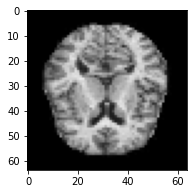

In [5]:
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE 

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

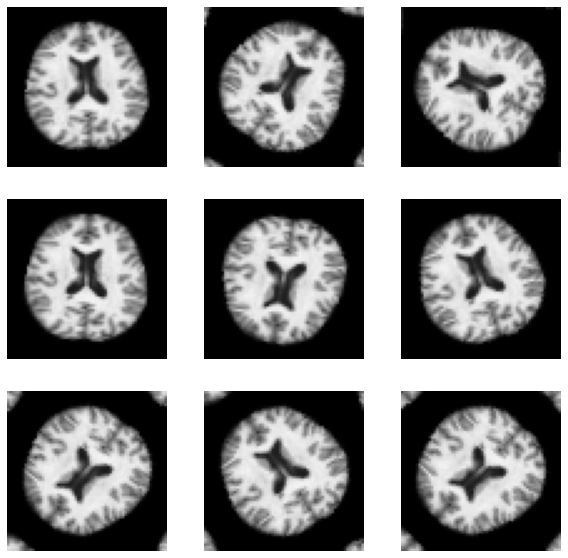

In [8]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
img_shape = (64, 64, 3)
base_model = tf.keras.applications.ResNet50(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 2, 2, 2048)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [24]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 2)


In [25]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

In [27]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [28]:
len(model.trainable_variables)

2

In [29]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

checkpoint_filepath = 'src/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [30]:
METRICS = [
        tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [31]:
initial_epochs = 50

history = model.fit(train_data,
                   validation_data = val_data,
                   callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback],
    epochs=epoch)

Epoch 1/100
64/65 [============================>.] - ETA: 0s - loss: 0.7288 - AUC: 0.5707 - precision: 0.5454 - recall: 0.5454WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: src/checkpoint/assets
65/65 [==============================] - 20s 308ms/step - loss: 0.7287 - AUC: 0.5708 - precision: 0.5455 - recall: 0.5455 - val_loss: 0.7215 - val_AUC: 0.6138 - val_precision: 0.5283 - val_recall: 0.5283
Epoch 2/100
65/65 [==============================] - 20s 305ms/step - loss: 0.6991 - AUC: 0.6021 - precision: 0.5721 - recall: 0.5721 - val_l

65/65 [==============================] - 4s 57ms/step - loss: 0.6466 - AUC: 0.6778 - precision: 0.6385 - recall: 0.6385 - val_loss: 0.6220 - val_AUC: 0.7156 - val_precision: 0.6562 - val_recall: 0.6562
Epoch 28/100
65/65 [==============================] - 4s 58ms/step - loss: 0.6478 - AUC: 0.6710 - precision: 0.6300 - recall: 0.6300 - val_loss: 0.6204 - val_AUC: 0.7176 - val_precision: 0.6621 - val_recall: 0.6621
Epoch 29/100
65/65 [==============================] - 4s 58ms/step - loss: 0.6490 - AUC: 0.6705 - precision: 0.6270 - recall: 0.6270 - val_loss: 0.6189 - val_AUC: 0.7239 - val_precision: 0.6621 - val_recall: 0.6621
Epoch 30/100
65/65 [==============================] - 4s 57ms/step - loss: 0.6497 - AUC: 0.6694 - precision: 0.6234 - recall: 0.6234 - val_loss: 0.6240 - val_AUC: 0.7065 - val_precision: 0.6504 - val_recall: 0.6504
Epoch 31/100
65/65 [==============================] - 20s 303ms/step - loss: 0.6430 - AUC: 0.6792 - precision: 0.6327 - recall: 0.6327 - val_loss: 0.6247

In [107]:

datagen = ImageDataGenerator(validation_split=0.2, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False)
train_generator = datagen.flow_from_directory(
        'Alz_data/train2',
        target_size=(64,64),
        batch_size=100,
        class_mode='categorical2',
        subset='training')
validation_generator = datagen.flow_from_directory(
        'Alz_data/train',
        target_size=(64,64),
        batch_size=100,
        class_mode='categorical',
        subset='validation')



Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [108]:
img_hist = model.fit(
        train_generator,
        validation_data=validation_generator,
        callbacks=[early_stopping_cb, lr_scheduler, model_checkpoint_callback], 
        epochs=epoch)

Epoch 1/100
41/41 [==============================] - 7s 181ms/step - loss: 1.0609 - AUC: 0.7898 - precision: 0.5331 - recall: 0.3755 - val_loss: 1.0050 - val_AUC: 0.8083 - val_precision: 0.5521 - val_recall: 0.3470
Epoch 2/100
41/41 [==============================] - 7s 160ms/step - loss: 0.9949 - AUC: 0.8084 - precision: 0.5756 - recall: 0.3531 - val_loss: 0.9973 - val_AUC: 0.8074 - val_precision: 0.6059 - val_recall: 0.4027
Epoch 3/100
41/41 [==============================] - 7s 159ms/step - loss: 0.9947 - AUC: 0.8092 - precision: 0.5843 - recall: 0.3680 - val_loss: 1.0158 - val_AUC: 0.7943 - val_precision: 0.4937 - val_recall: 0.3050
Epoch 4/100
41/41 [==============================] - 7s 159ms/step - loss: 0.9836 - AUC: 0.8139 - precision: 0.5958 - recall: 0.3702 - val_loss: 0.9728 - val_AUC: 0.8161 - val_precision: 0.6126 - val_recall: 0.3617
Epoch 5/100
41/41 [==============================] - 6s 158ms/step - loss: 0.9823 - AUC: 0.8141 - precision: 0.6055 - recall: 0.3641 - val_l

In [109]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'Alz_data/test/',
            labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
)

Found 1279 files belonging to 4 classes.


In [110]:
score = model.evaluate(test_data)

20/20 [==============================] - 1s 48ms/step - loss: 0.9767 - AUC: 0.8299 - precision: 0.5655 - recall: 0.4762
